In [39]:
# Foundations of Data Science 
# Members: Tashrif Chowdhury (tc2367), Terrell Nowlin (trn224), Akhilesh Chandrashekar (ab10138), Zhenghao Li(zl3954), 
#          Faiz Andrea Ganz (fag277)
# Yelp Reviews: Fraud Detection
# December 9th, 2021

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string

%matplotlib inline

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('reviewContent', sep="\t", names=['user_id', 'prod_id', 'date', 'review'])
meta = pd.read_csv('metadata', sep='\t', names = ['user_id', 'prod_id', 'rating', 'label', 'date'])

df = pd.merge(data, meta, on = ['user_id', 'date', 'prod_id'])

df.loc[df.label == 1, 'label'] = 0
df.loc[df.label == -1, 'label'] = 1

# Include other features as text
df.loc[df.label == 0, 'review'] = '#user_id:' + (df.loc[df.label == 0, 'user_id'].astype(str) + ' '
                                + '#prod_id:' + df.loc[df.label == 0, 'prod_id'].astype(str) + ' '
                                + '#date:' + df.loc[df.label == 0, 'date'].astype(str) + ' '
                                + '#rating:' + df.loc[df.label == 0, 'rating'].astype(str) + ' '
                                + '#review:' + df.loc[df.label == 0, 'review'])

df.loc[df.label == 1, 'review'] = '#user_id:' + (df.loc[df.label == 1, 'user_id'].astype(str) + ' '
                                + '#prod_id:' + df.loc[df.label == 1, 'prod_id'].astype(str) + ' '
                                + '#date:' + df.loc[df.label == 1, 'date'].astype(str) + ' '
                                + '#rating:' + df.loc[df.label == 1, 'rating'].astype(str) + ' '
                                + '#review:' + df.loc[df.label == 1, 'review'])

df = df[['review', 'label']]

In [34]:
df.label.value_counts()

0    322097
1     36860
Name: label, dtype: int64

In [4]:
# df = df.head(10000)

In [5]:
# Get X and y values
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [7]:
# Undersampling on training data
ros = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [37]:
y_resampled.value_counts()

0    24696
1    24696
Name: label, dtype: int64

In [38]:
len(y_resampled)

49392

In [8]:
X_test = X_test.head(10000)
y_test = y_test.head(10000)

In [9]:
# CountVectorizer

cv = CountVectorizer(stop_words="english", ngram_range=(1,2), binary=True)

X_train_cv = cv.fit_transform(X_resampled.review.values.tolist())
X_test_cv = cv.transform(X_test.review.values.tolist())

In [10]:
# TfidfVectorizer

tf_idf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), binary=True)

X_train_tf_idf = tf_idf.fit_transform(X_resampled.review.values.tolist())
X_test_tf_idf = tf_idf.transform(X_test.review.values.tolist())

In [11]:
# RandomForest - TfidfVectorizer
rf_tf_idf = RandomForestClassifier()
rf_tf_idf.fit(X_train_tf_idf, y_resampled)
y_pred_rf_tf_idf = rf_tf_idf.predict_proba(X_test_tf_idf)
y_predictions_rf_tf_idf = rf_tf_idf.predict(X_test_tf_idf)
fpr_rf_tf_idf, tpr_rf_tf_idf, thresholds_rf_tf_idf = metrics.roc_curve(y_test, y_pred_rf_tf_idf[:,1], pos_label = 1)
roc_auc_score_rf_tf_idf = metrics.auc(fpr_rf_tf_idf, tpr_rf_tf_idf)

0.5543
              precision    recall  f1-score   support

           0       0.95      0.53      0.68      8982
           1       0.15      0.75      0.26      1018

    accuracy                           0.55     10000
   macro avg       0.55      0.64      0.47     10000
weighted avg       0.87      0.55      0.64     10000



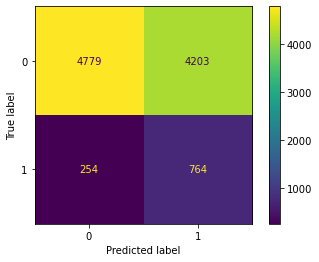

In [12]:
print(accuracy_score(y_test,y_predictions_rf_tf_idf))
print(classification_report(y_test,y_predictions_rf_tf_idf))

cm = confusion_matrix(y_test, y_predictions_rf_tf_idf.tolist())
display = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
display.plot()
plt.show()

In [35]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_rf_tf_idf, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_rf_tf_idf, tpr_rf_tf_idf)))

Testing F1 score: 0.6385477014214689
Testing AUC score: 0.6960147100575305


In [13]:
# RandomForest - CountVectorizer
rf_cv = RandomForestClassifier()
rf_cv.fit(X_train_cv, y_resampled)
y_pred_rf_cv = rf_cv.predict_proba(X_test_cv)
y_predictions_rf_cv = rf_cv.predict(X_test_cv)
fpr_rf_cv, tpr_rf_cv, thresholds_rf_cv = metrics.roc_curve(y_test, y_pred_rf_cv[:,1], pos_label = 1)
roc_auc_score_rf_cv = metrics.auc(fpr_rf_cv, tpr_rf_cv)

0.5962
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      8982
           1       0.16      0.72      0.27      1018

    accuracy                           0.60     10000
   macro avg       0.56      0.65      0.49     10000
weighted avg       0.87      0.60      0.68     10000



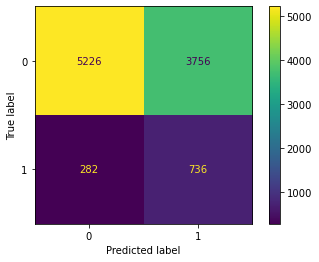

In [14]:
print(accuracy_score(y_test,y_predictions_rf_cv))
print(classification_report(y_test,y_predictions_rf_cv))

confusion_matrix = confusion_matrix(y_test, y_predictions_rf_cv)
display = ConfusionMatrixDisplay(confusion_matrix, display_labels = [0, 1])
display.plot()
plt.show()

In [36]:
print('Testing F1 score: {}'.format(metrics.f1_score(y_test, y_predictions_rf_cv, average='weighted')))
print('Testing AUC score: {}'.format(metrics.auc(fpr_rf_cv, tpr_rf_cv)))

Testing F1 score: 0.6750900961549301
Testing AUC score: 0.7098853896397904


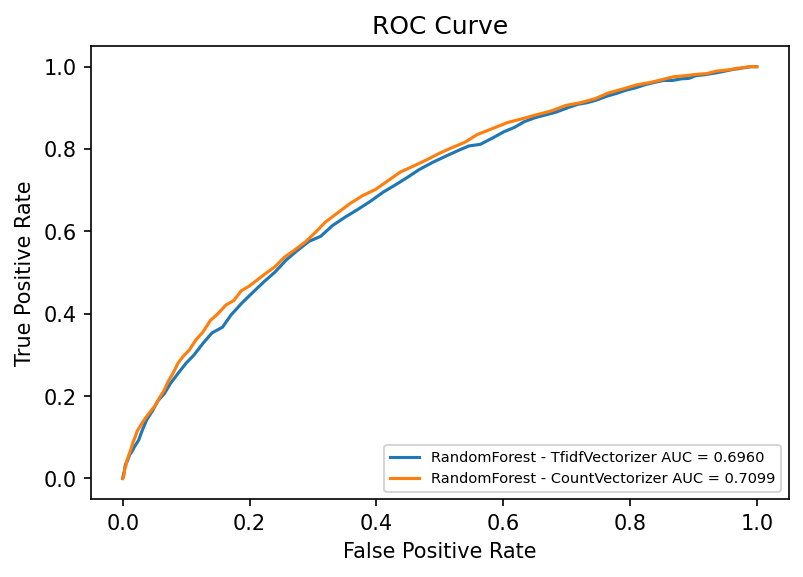

In [15]:
#Plot
plt.rcParams['figure.dpi'] = 150
plt.plot(fpr_rf_tf_idf, tpr_rf_tf_idf, label="RandomForest - TfidfVectorizer AUC = {:.4f}".format(roc_auc_score_rf_tf_idf))
plt.plot(fpr_rf_cv, tpr_rf_cv, label="RandomForest - CountVectorizer AUC = {:.4f}".format(roc_auc_score_rf_cv))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right', fontsize=7)
plt.show()

# Parameter Tuning

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [18]:
param_grid_rf ={'n_estimators':[20,30,40],'min_samples_split':[2, 5],'min_samples_leaf':[1,2]}

In [19]:
search = RandomizedSearchCV(rf_cv, param_grid_rf, scoring='accuracy')

In [20]:
result = search.fit(X_train_cv, y_resampled)

In [21]:
 # summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6491940801167297
Best Hyperparameters: {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [23]:
grid_pred = result.best_estimator_.predict(X_test_tf_idf)

In [24]:
print('Testing accuracy %s' % accuracy_score(y_test, grid_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, grid_pred, average='weighted')))
fpr, tpr, thresholds = roc_curve(y_test, grid_pred, pos_label = 1)
print('Testing AUC score: {}'.format(auc(fpr, tpr)))

Testing accuracy 0.1018
Testing F1 score: 0.018811472136503905
Testing AUC score: 0.5
